In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Loading Starting Moneyline Data

In [3]:
df = pd.read_parquet('s3://moneygans-data/basketball_nba/starting_money/starting_money_agg/starting_money_all.parquet', engine='pyarrow')[['pos_money','neg_money']]
df.head()

,pos_money,neg_money
0,380,-500
1,340,-500
2,400,-550
3,400,-550
4,400,-525


#### Empirical Starting Moneyline Distribution

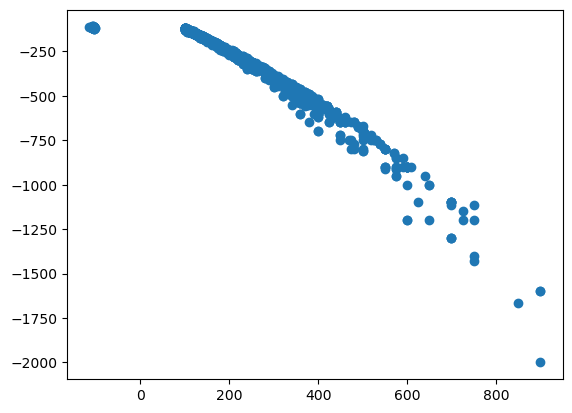

In [6]:
plt.scatter(df['pos_money'], df['neg_money'])

##### Converting df to array

In [52]:
data = df.values.astype(np.float32)
data.shape

(942, 2)

### Initial WGAN Network with Weight Clipping

In [41]:
# Convert data to PyTorch tensor
real_data = torch.tensor(data)

# Create a PyTorch dataset and dataloader
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration
weight_clip = 0.01

# Initialize models and optimizers
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.RMSprop(G.parameters(), lr=lr)
optimizer_C = optim.RMSprop(C.parameters(), lr=lr)

# Training loop
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader):
        real_samples = data[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

            # Weight clipping
            for p in C.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(1000, noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()


Epoch 0, Loss C: -0.2168, Loss G: -0.0097
Epoch 500, Loss C: -0.1158, Loss G: -0.6210
Epoch 1000, Loss C: -0.0146, Loss G: 0.2375
Epoch 1500, Loss C: -0.0085, Loss G: 0.0975
Epoch 2000, Loss C: -0.0238, Loss G: -0.1991
Epoch 2500, Loss C: -0.0386, Loss G: -0.4293
Epoch 3000, Loss C: 0.0459, Loss G: 0.7404
Epoch 3500, Loss C: -0.0227, Loss G: -0.6225
Epoch 4000, Loss C: -0.0278, Loss G: -0.2095
Epoch 4500, Loss C: -0.0163, Loss G: -0.4324


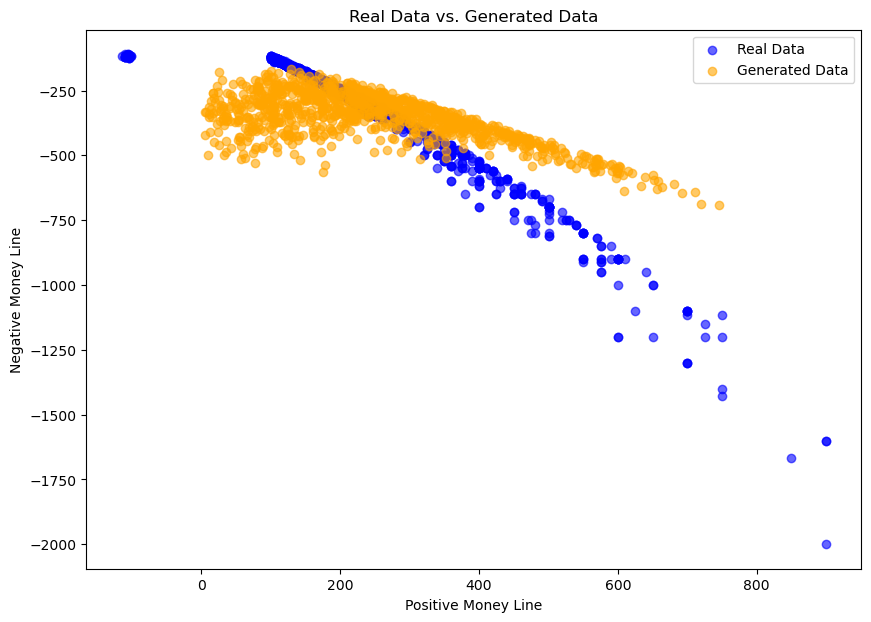

In [42]:
# Plot real data vs. generated data
real_data_np = real_data.numpy()

plt.figure(figsize=(10, 7))
plt.scatter(real_data_np[:, 0], real_data_np[:, 1], label='Real Data', color='blue', alpha=0.6)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label='Generated Data', color='orange', alpha=0.6)
plt.title('Real Data vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

### Larger network using batch normalization

In [47]:
# Normalize the data for better training stability

scaler = MinMaxScaler()
data_norm = scaler.fit_transform(data)

# Convert data to PyTorch tensor
real_data = torch.tensor(data_norm)

# Create a PyTorch dataset and dataloader
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network with Batch Normalization and more layers
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),  # Use LayerNorm in Critic as per WGAN guidelines
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration
weight_clip = 0.01

# Initialize models and optimizers
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.RMSprop(G.parameters(), lr=lr)
optimizer_C = optim.RMSprop(C.parameters(), lr=lr)

# Training loop
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader):
        real_samples = data[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

            # Weight clipping
            for p in C.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(1000, noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())


Epoch 0, Loss C: -0.0000, Loss G: 0.0099
Epoch 500, Loss C: -0.0019, Loss G: 0.0068
Epoch 1000, Loss C: -0.0012, Loss G: 0.0151
Epoch 1500, Loss C: 0.0000, Loss G: 0.0172
Epoch 2000, Loss C: 0.0012, Loss G: 0.0009
Epoch 2500, Loss C: 0.0000, Loss G: 0.0162
Epoch 3000, Loss C: -0.0002, Loss G: 0.0106
Epoch 3500, Loss C: 0.0000, Loss G: 0.0067
Epoch 4000, Loss C: 0.0001, Loss G: 0.0128
Epoch 4500, Loss C: 0.0001, Loss G: 0.0077


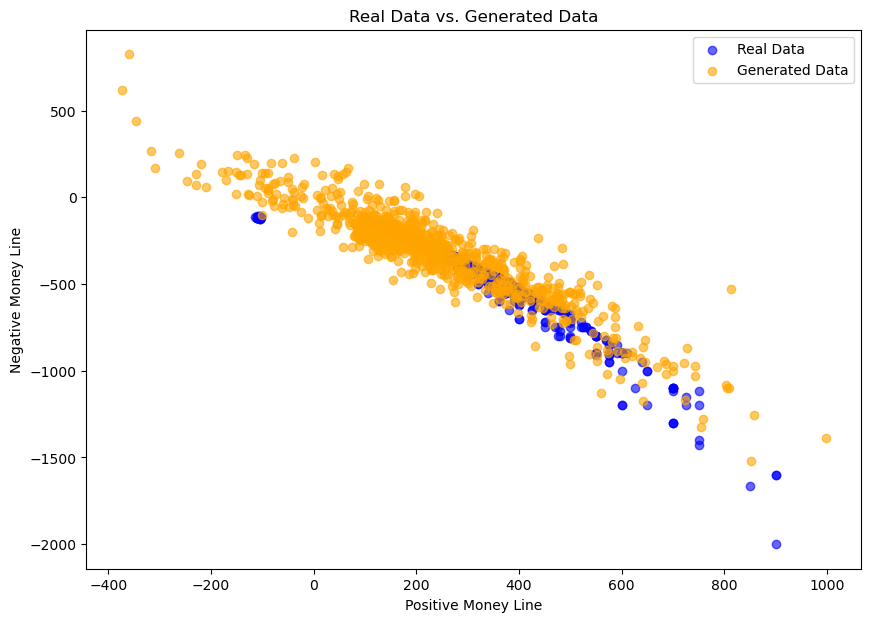

In [48]:
# Plot real data vs. generated data
plt.figure(figsize=(10, 7))
plt.scatter(real_data_np[:, 0], real_data_np[:, 1], label='Real Data', color='blue', alpha=0.6)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label='Generated Data', color='orange', alpha=0.6)
plt.title('Real Data vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

### Spectral Normalization Model w/ visualizations

In [54]:
# Create a PyTorch dataset and dataloader
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network with Spectral Normalization and more layers
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(128, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(256, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(128, 1)),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration

# Initialize models and optimizers
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_C = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))

# Lists to store loss values for visualization
losses_G = []
losses_C = []

# Training loop
for epoch in range(1, n_epochs + 1):
    for i, data in enumerate(dataloader):
        real_samples = data[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Store losses for plotting
    losses_G.append(loss_G.item())
    losses_C.append(loss_C.item())

    if epoch % 500 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

Epoch 1, Loss C: -0.3377, Loss G: 0.1003
Epoch 500, Loss C: -0.0054, Loss G: -0.1391
Epoch 1000, Loss C: -0.0032, Loss G: -0.0870
Epoch 1500, Loss C: -0.0018, Loss G: -0.0363
Epoch 2000, Loss C: -0.0009, Loss G: -0.0457
Epoch 2500, Loss C: -0.0035, Loss G: -0.2760
Epoch 3000, Loss C: -0.0013, Loss G: -0.3877
Epoch 3500, Loss C: -0.0019, Loss G: -0.5254
Epoch 4000, Loss C: -0.0025, Loss G: -0.9888
Epoch 4500, Loss C: -0.0036, Loss G: -0.1125
Epoch 5000, Loss C: 0.0217, Loss G: -1.1998


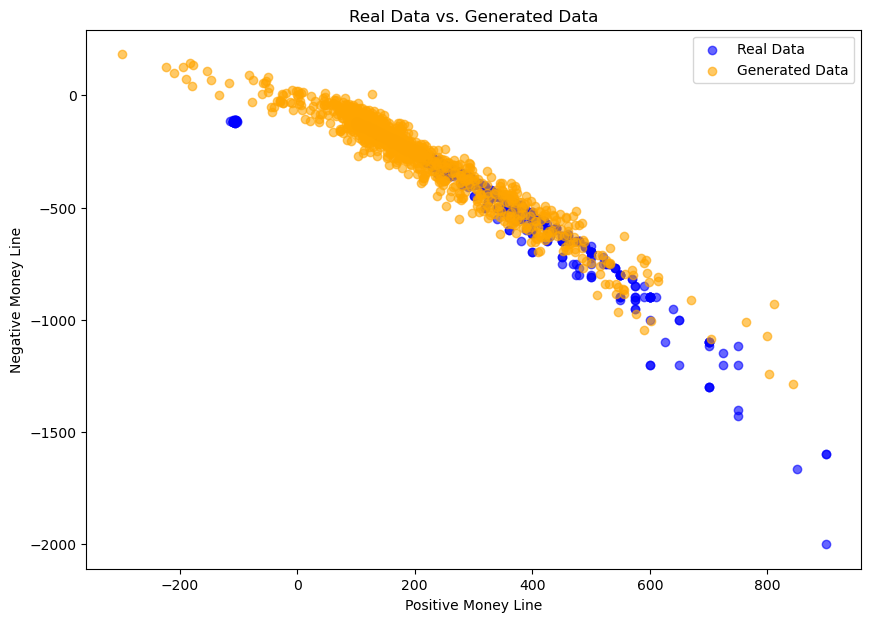

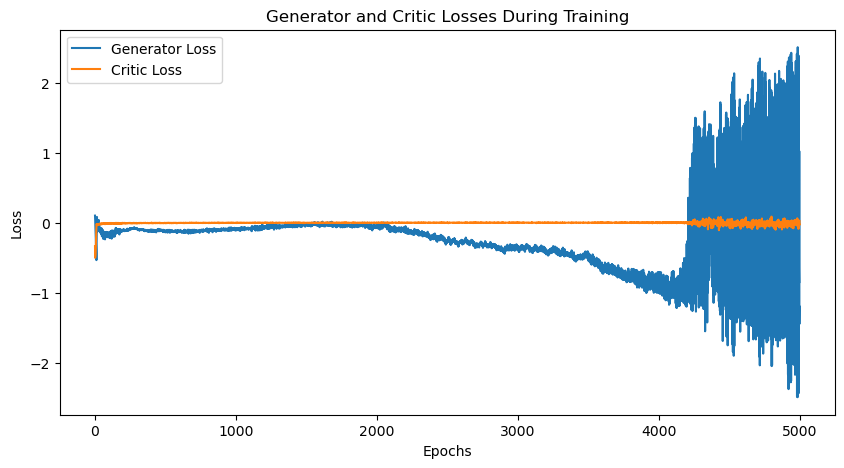

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

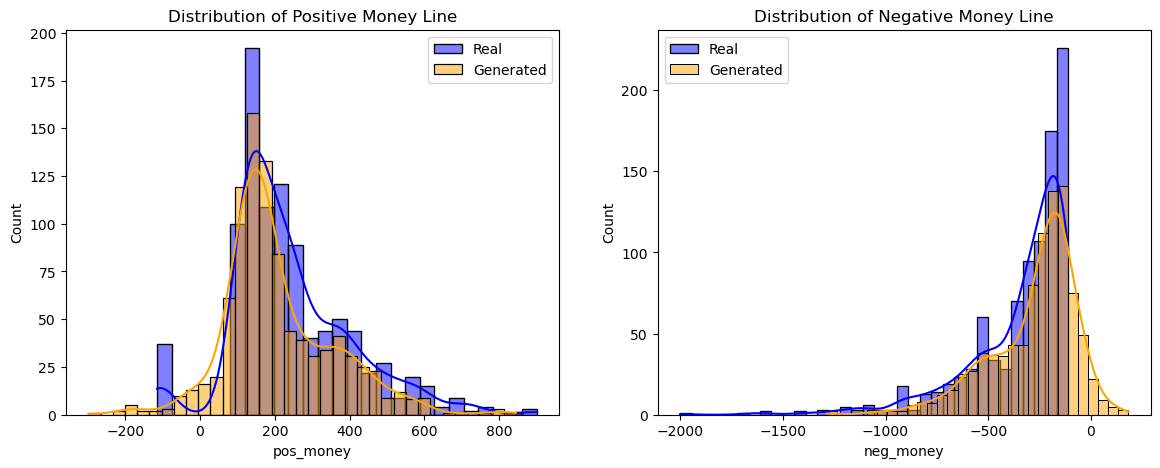

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

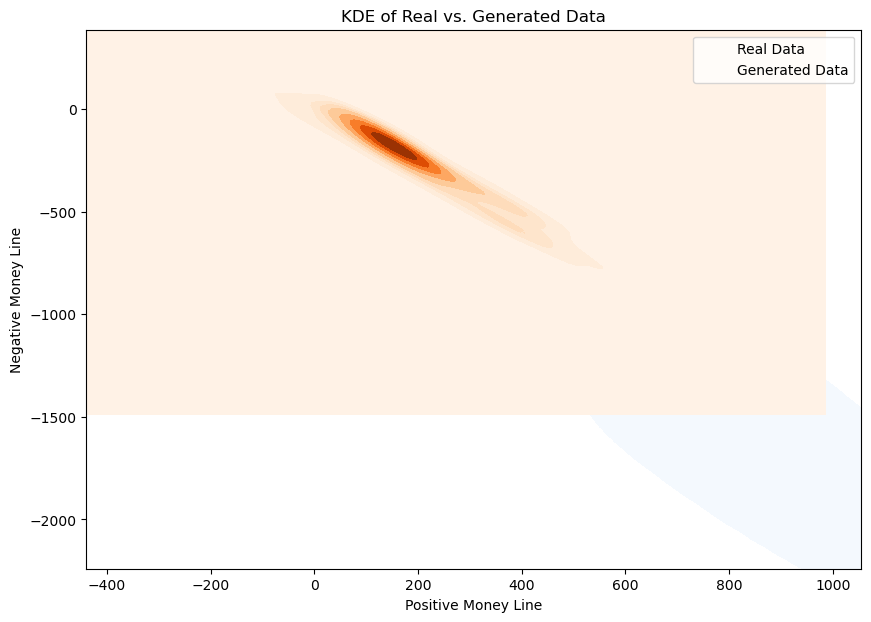

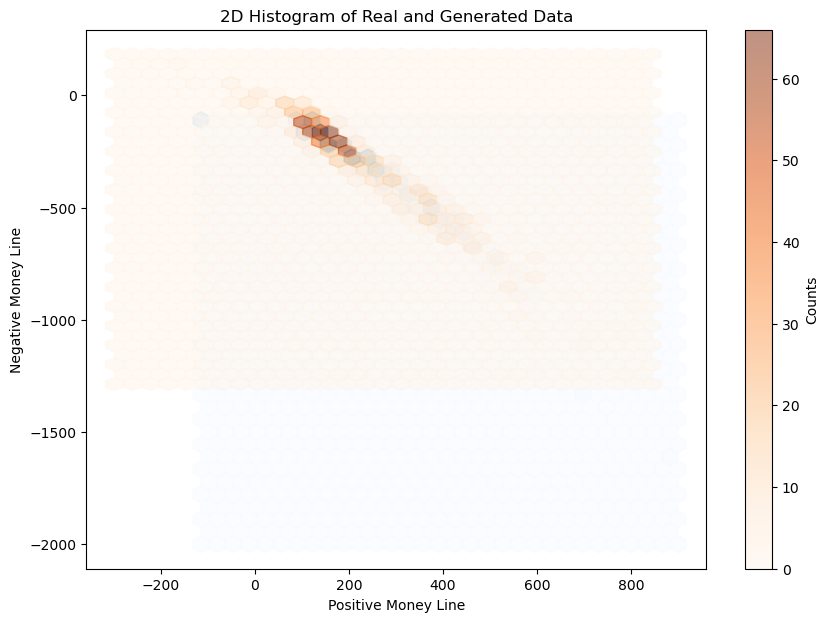

KS Test for 'pos_money': KS Statistic = 0.1486, p-value = 0.0000
KS Test for 'neg_money': KS Statistic = 0.1741, p-value = 0.0000


In [57]:
# Generate synthetic data
with torch.no_grad():
    z = torch.randn(len(real_data), noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Convert to DataFrames for easier plotting
real_df = pd.DataFrame(real_data_np, columns=['pos_money', 'neg_money'])
gen_df = pd.DataFrame(generated_samples, columns=['pos_money', 'neg_money'])

# Plot real data vs. generated data
plt.figure(figsize=(10, 7))
plt.scatter(real_df['pos_money'], real_df['neg_money'], label='Real Data', color='blue', alpha=0.6)
plt.scatter(gen_df['pos_money'], gen_df['neg_money'], label='Generated Data', color='orange', alpha=0.6)
plt.title('Real Data vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

# Plot Generator and Critic Losses
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_C, label='Critic Loss')
plt.title('Generator and Critic Losses During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot histograms of individual features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(real_df['pos_money'], kde=True, color='blue', label='Real', ax=axes[0])
sns.histplot(gen_df['pos_money'], kde=True, color='orange', label='Generated', ax=axes[0])
axes[0].set_title('Distribution of Positive Money Line')
axes[0].legend()

sns.histplot(real_df['neg_money'], kde=True, color='blue', label='Real', ax=axes[1])
sns.histplot(gen_df['neg_money'], kde=True, color='orange', label='Generated', ax=axes[1])
axes[1].set_title('Distribution of Negative Money Line')
axes[1].legend()
plt.show()

# Plot KDE of the joint distribution
plt.figure(figsize=(10, 7))
sns.kdeplot(data=real_df, x='pos_money', y='neg_money', cmap='Blues', fill=True, thresh=0, levels=10, label='Real Data')
sns.kdeplot(data=gen_df, x='pos_money', y='neg_money', cmap='Oranges', fill=True, thresh=0, levels=10, label='Generated Data')
plt.title('KDE of Real vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

# 2D Histogram (Hexbin Plot)
plt.figure(figsize=(10, 7))
plt.hexbin(real_df['pos_money'], real_df['neg_money'], gridsize=30, cmap='Blues', alpha=0.5, label='Real Data')
plt.hexbin(gen_df['pos_money'], gen_df['neg_money'], gridsize=30, cmap='Oranges', alpha=0.5, label='Generated Data')
plt.title('2D Histogram of Real and Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.colorbar(label='Counts')
plt.show()

# Statistical Comparison: Kolmogorov-Smirnov Test
from scipy.stats import ks_2samp

ks_stat_pos, p_value_pos = ks_2samp(real_df['pos_money'], gen_df['pos_money'])
ks_stat_neg, p_value_neg = ks_2samp(real_df['neg_money'], gen_df['neg_money'])

print(f"KS Test for 'pos_money': KS Statistic = {ks_stat_pos:.4f}, p-value = {p_value_pos:.4f}")
print(f"KS Test for 'neg_money': KS Statistic = {ks_stat_neg:.4f}, p-value = {p_value_neg:.4f}")


## Spectral Normalization, Larger Network with Dropout

In [62]:
# Create a PyTorch dataset and dataloader
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization, Dropout, and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network with Spectral Normalization, Dropout, and more layers
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 1)),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_C = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))

# Lists to store loss values for visualization
losses_G = []
losses_C = []

# Training loop
for epoch in range(1, n_epochs + 1):
    for i, data_batch in enumerate(dataloader):
        real_samples = data_batch[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Store losses for plotting
    losses_G.append(loss_G.item())
    losses_C.append(loss_C.item())

    if epoch % 500 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(len(real_data), noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Convert to DataFrames for easier plotting
real_df = pd.DataFrame(real_data_np, columns=['pos_money', 'neg_money'])
gen_df = pd.DataFrame(generated_samples, columns=['pos_money', 'neg_money'])


Using device: cpu
Epoch 1, Loss C: -0.3807, Loss G: 0.1175
Epoch 500, Loss C: -0.0215, Loss G: -0.1401
Epoch 1000, Loss C: 0.0057, Loss G: -0.0831
Epoch 1500, Loss C: -0.0062, Loss G: -0.0773
Epoch 2000, Loss C: -0.0190, Loss G: -0.0815
Epoch 2500, Loss C: 0.0086, Loss G: -0.0757
Epoch 3000, Loss C: -0.0009, Loss G: 0.0123
Epoch 3500, Loss C: -0.0367, Loss G: 0.0456
Epoch 4000, Loss C: 0.0096, Loss G: 0.1508
Epoch 4500, Loss C: -0.0202, Loss G: 0.1186
Epoch 5000, Loss C: 0.0028, Loss G: 0.1226


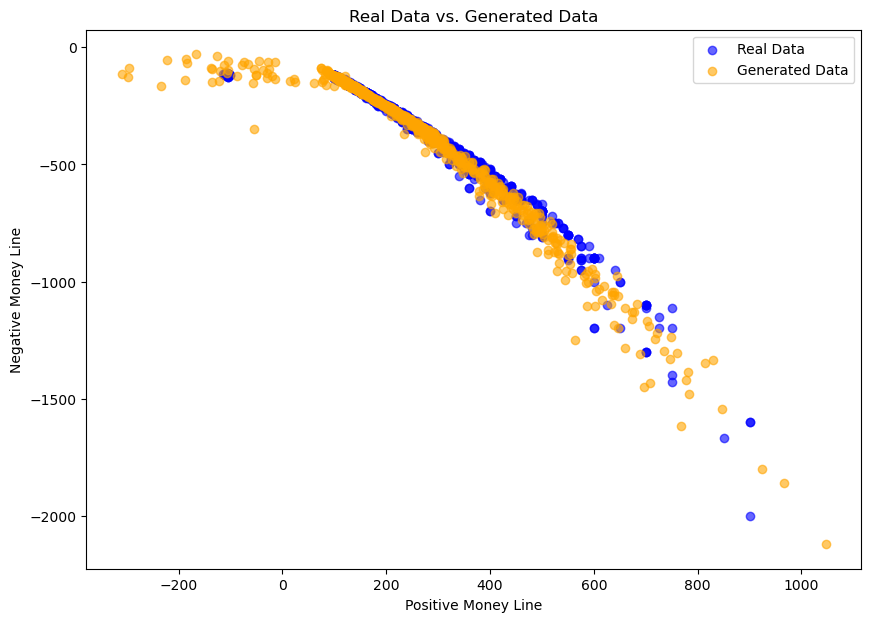

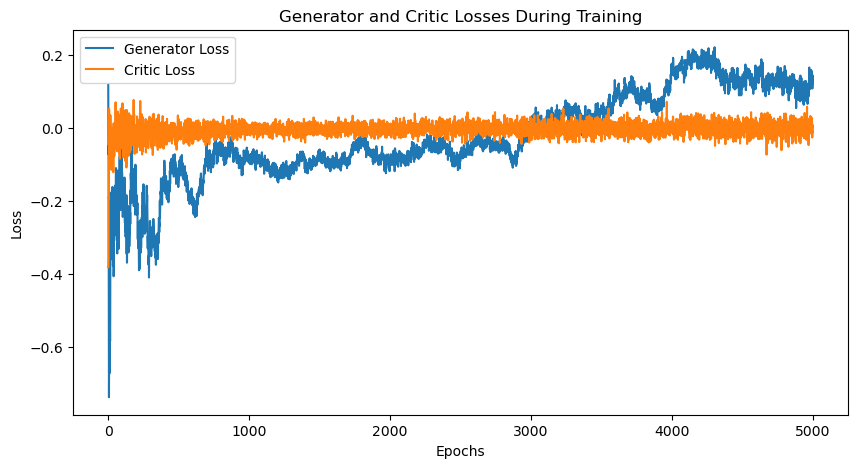

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

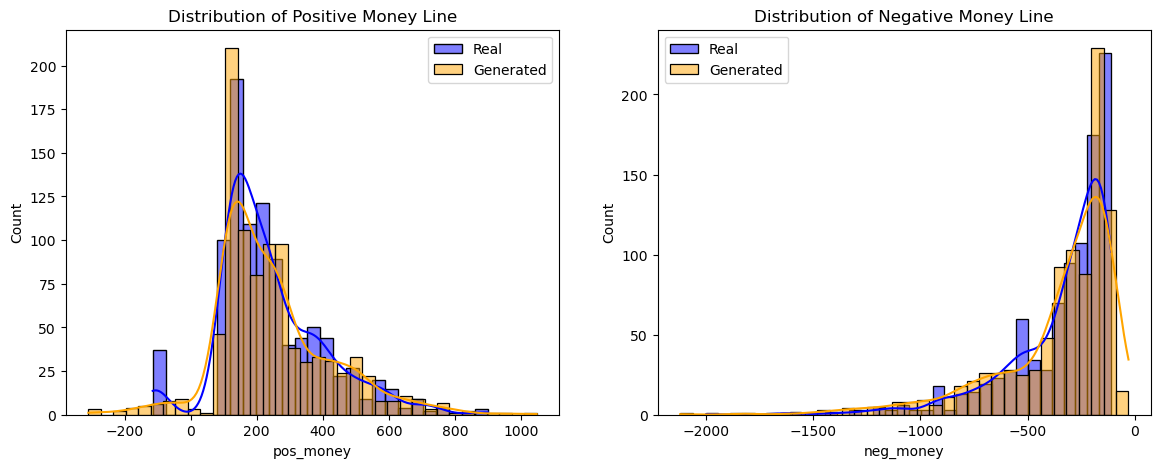

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

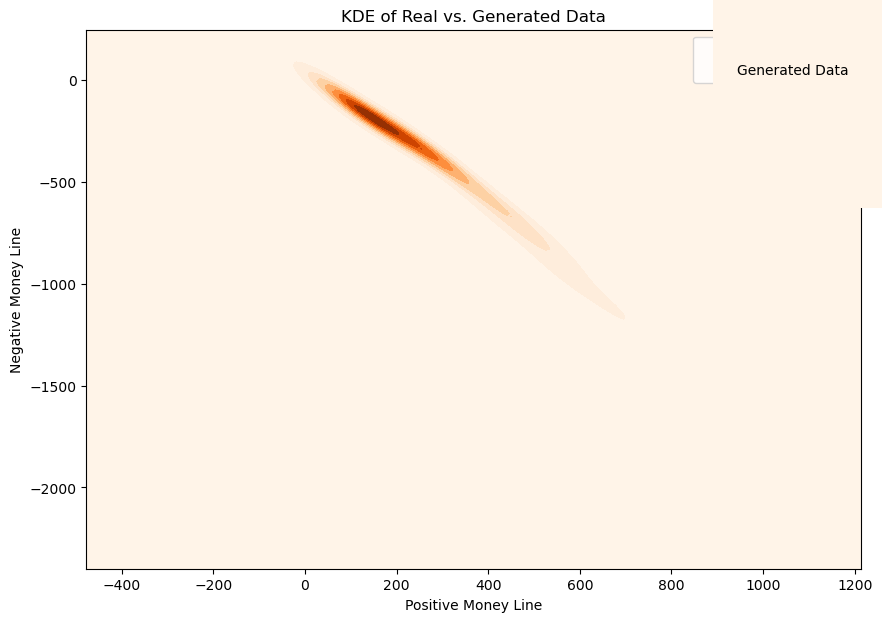

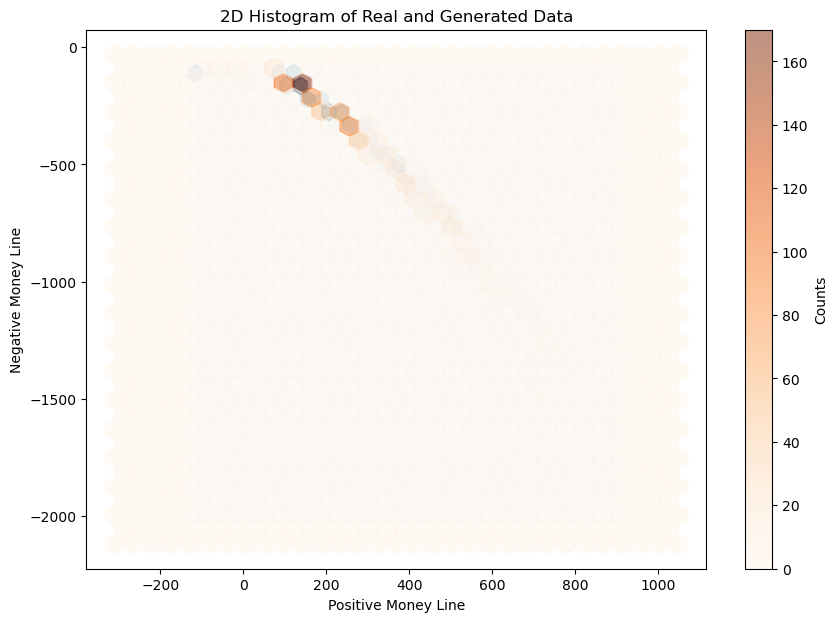

KS Test for 'pos_money': KS Statistic = 0.0584, p-value = 0.0806
KS Test for 'neg_money': KS Statistic = 0.0488, p-value = 0.2114


In [63]:
# Plot real data vs. generated data
plt.figure(figsize=(10, 7))
plt.scatter(real_df['pos_money'], real_df['neg_money'], label='Real Data', color='blue', alpha=0.6)
plt.scatter(gen_df['pos_money'], gen_df['neg_money'], label='Generated Data', color='orange', alpha=0.6)
plt.title('Real Data vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

# Plot Generator and Critic Losses
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_C, label='Critic Loss')
plt.title('Generator and Critic Losses During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot histograms of individual features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(real_df['pos_money'], kde=True, color='blue', label='Real', ax=axes[0])
sns.histplot(gen_df['pos_money'], kde=True, color='orange', label='Generated', ax=axes[0])
axes[0].set_title('Distribution of Positive Money Line')
axes[0].legend()

sns.histplot(real_df['neg_money'], kde=True, color='blue', label='Real', ax=axes[1])
sns.histplot(gen_df['neg_money'], kde=True, color='orange', label='Generated', ax=axes[1])
axes[1].set_title('Distribution of Negative Money Line')
axes[1].legend()
plt.show()

# Plot KDE of the joint distribution
plt.figure(figsize=(10, 7))
sns.kdeplot(data=real_df, x='pos_money', y='neg_money', cmap='Blues', fill=True, thresh=0, levels=10, label='Real Data')
sns.kdeplot(data=gen_df, x='pos_money', y='neg_money', cmap='Oranges', fill=True, thresh=0, levels=10, label='Generated Data')
plt.title('KDE of Real vs. Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

# 2D Histogram (Hexbin Plot)
plt.figure(figsize=(10, 7))
plt.hexbin(real_df['pos_money'], real_df['neg_money'], gridsize=30, cmap='Blues', alpha=0.5)
plt.hexbin(gen_df['pos_money'], gen_df['neg_money'], gridsize=30, cmap='Oranges', alpha=0.5)
plt.title('2D Histogram of Real and Generated Data')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.colorbar(label='Counts')
plt.show()

# Statistical Comparison: Kolmogorov-Smirnov Test
from scipy.stats import ks_2samp

ks_stat_pos, p_value_pos = ks_2samp(real_df['pos_money'], gen_df['pos_money'])
ks_stat_neg, p_value_neg = ks_2samp(real_df['neg_money'], gen_df['neg_money'])

print(f"KS Test for 'pos_money': KS Statistic = {ks_stat_pos:.4f}, p-value = {p_value_pos:.4f}")
print(f"KS Test for 'neg_money': KS Statistic = {ks_stat_neg:.4f}, p-value = {p_value_neg:.4f}")
